In [1]:
# ## comment out if running locally and SEM is already installed
# !pip install git+https://github.com/nicktfranklin/SEM2



In [2]:
import sys
print("Python version")
print (sys.version)

Python version
3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]


In [3]:
import os
os.chdir('../')



In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sem.event_models import LinearEvent, NonLinearEvent, RecurrentLinearEvent
from sem.event_models import RecurrentEvent, GRUEvent, LSTMEvent
from sem import sem_run
from sklearn import metrics




TensorFlow Version: 2.3.1


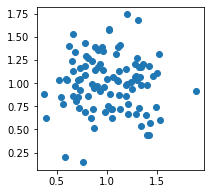

In [5]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [6]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

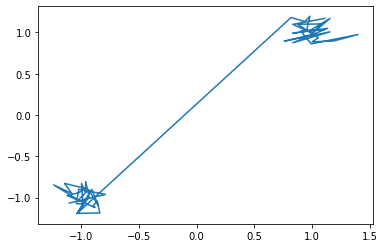

In [7]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(int(N/2)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(int(N/2), N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [8]:
# SEM parameters
lmda = 10.0  # stickyness parameter
alfa = .01  # concentration parameter


# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
    axes[0].set_xlabel(r'$\mathbf{x}_{s,1}$')
    axes[0].set_ylabel(r'$\mathbf{x}_{s,2}$')


    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Cluster ID')
    print("Adjusted Rand Score: {}\n".format(metrics.adjusted_rand_score(y, y_hat)))
    print(np.argmax(post, axis=1))

### Linear Events 

Run SEM: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


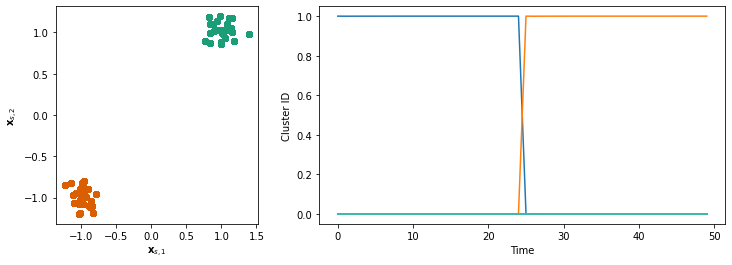

In [9]:
# Initialize keras model
sem_kwargs2 = dict(
    lmda=lmda, alfa=alfa, f_class=LinearEvent, 
    f_opts=dict(l2_regularization=0.4)  
)
# using the f_opts kwargs, we can set options for the event model as well.  Here, 
# we've added l2 regularization to the network, but normally this can just be left empty


results = sem_run(x_train, sem_kwargs2)
plot_segmentation(results.post, y)

### Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s]


Adjusted Rand Score: 0.9199693343555215

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


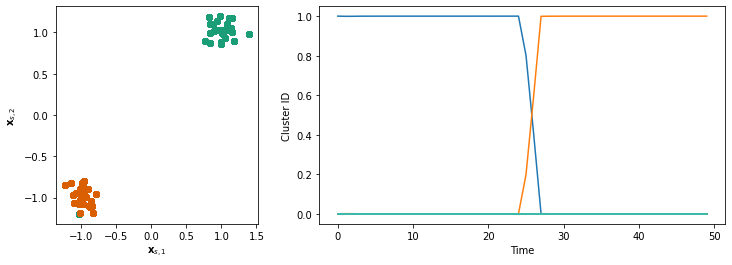

In [10]:
# Initialize keras model
sem_kwargs3 = dict(
    lmda=lmda, alfa=alfa, f_class=NonLinearEvent,
    f_opts=dict()
)

results = sem_run(x_train, sem_kwargs3)
plot_segmentation(results.post, y)

###  Recurrent Linear Events

Run SEM: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


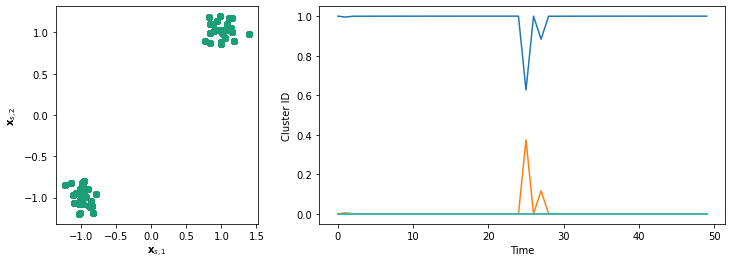

In [11]:
# Initialize keras model
sem_kwargs4 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurrentLinearEvent, 
    f_opts=dict(t=3)
)

results = sem_run(x_train, sem_kwargs4)
plot_segmentation(results.post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


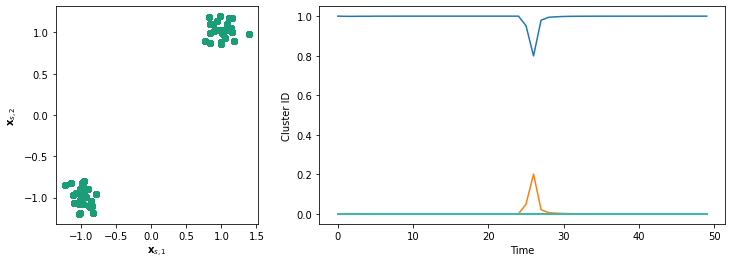

In [12]:
sem_kwargs5 = dict(
    lmda=lmda, alfa=alfa, f_class=RecurrentEvent,
    f_opts=dict(t=3)
)

results = sem_run(x_train, sem_kwargs5)
plot_segmentation(results.post, y)

### Gated Recurrent Unit Events 
Note: this is the default event type of the model

Run SEM: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


Adjusted Rand Score: 0.9199693343555215

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


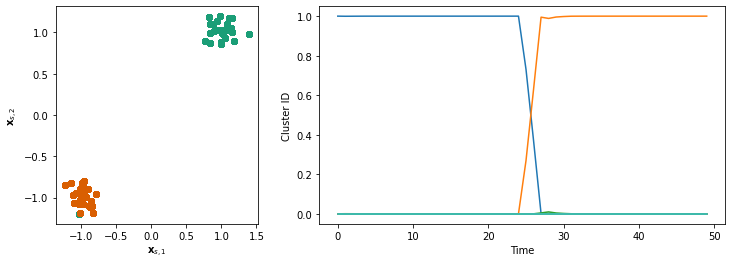

In [13]:
sem_kwargs6 = dict(
    lmda=lmda, alfa=alfa, f_class=GRUEvent,
    f_opts=dict(t=3)
)

results = sem_run(x_train, sem_kwargs6)
plot_segmentation(results.post, y)

# sem_model = SEM(**sem_kwargs6)
# sem_model.run(x_train)
# plot_segmentation(sem_model.results.post, y)

### LSTM Events

Run SEM: 100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


Adjusted Rand Score: 0.8432209038794828

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


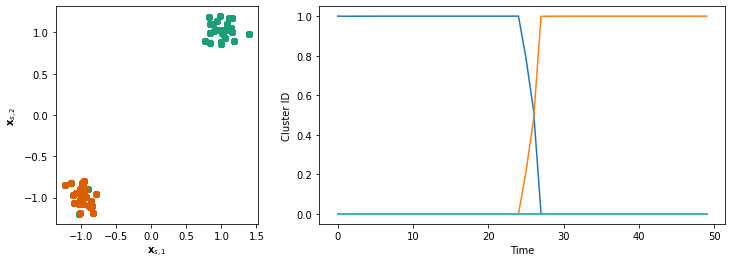

In [14]:
sem_kwargs7 = dict(
    lmda=lmda, alfa=alfa, f_class=LSTMEvent,
    f_opts=dict(t=3)
               )

results = sem_run(x_train, sem_kwargs7)
plot_segmentation(results.post, y)

# Alternating between 2 static events


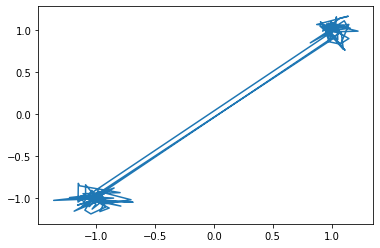

In [15]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(int(N/4)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(int(N/4), int(N/2)):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(int(N/2), int(N/4*3)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(int(N/4*3), N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:12<00:00,  8.18it/s]


Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


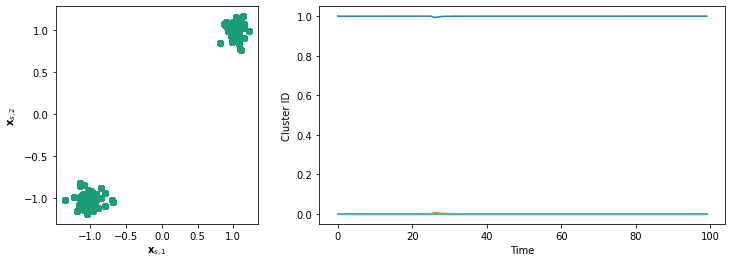

In [16]:
results = sem_run(x_train, sem_kwargs2)
plot_segmentation(results.post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


Adjusted Rand Score: 0.9599960816486464

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


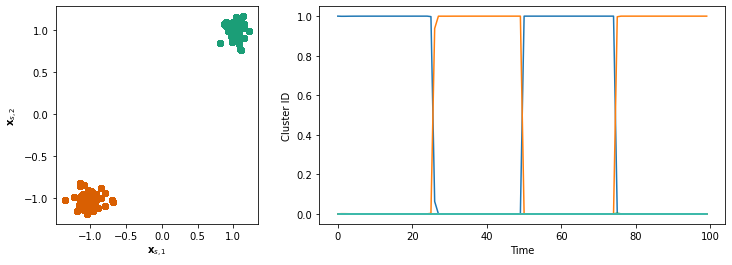

In [17]:
results = sem_run(x_train, sem_kwargs3)
plot_segmentation(results.post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


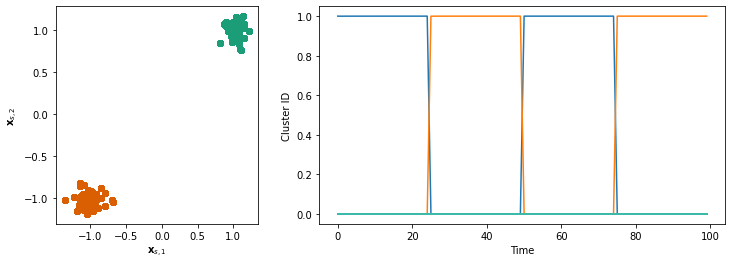

In [18]:
results = sem_run(x_train, sem_kwargs4)
plot_segmentation(results.post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


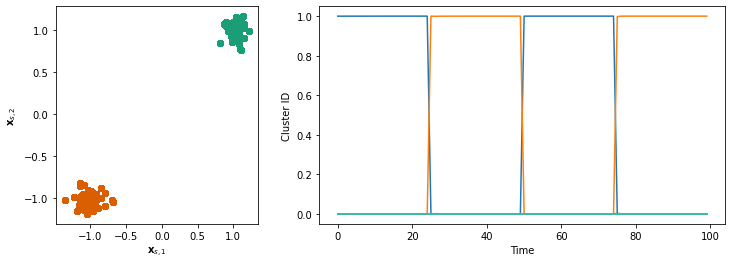

In [19]:
results = sem_run(x_train, sem_kwargs5)
plot_segmentation(results.post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


Adjusted Rand Score: 0.9599960816486464

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


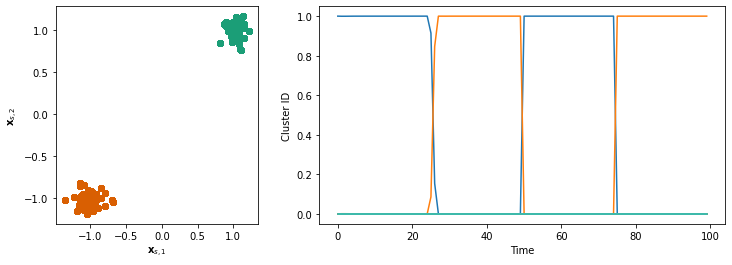

In [20]:
results = sem_run(x_train, sem_kwargs6)
plot_segmentation(results.post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:13<00:00,  7.42it/s]


Adjusted Rand Score: 0.9599960816486464

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


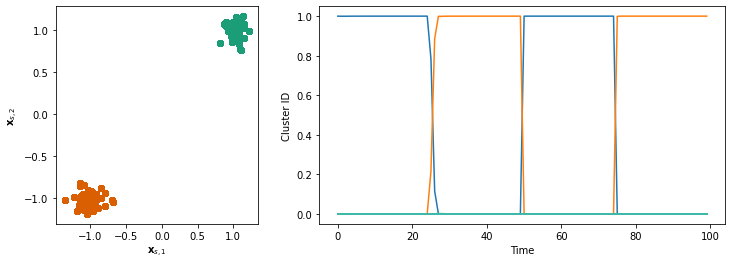

In [21]:
results = sem_run(x_train, sem_kwargs7)
plot_segmentation(results.post, y)

# Example of four events where the events correspond to movement in vector space

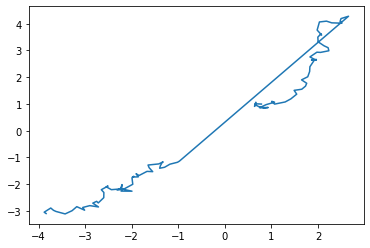

In [22]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, int(N/2)):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[int(N/2), :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(int(N/2+1), N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events 

Run SEM: 100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


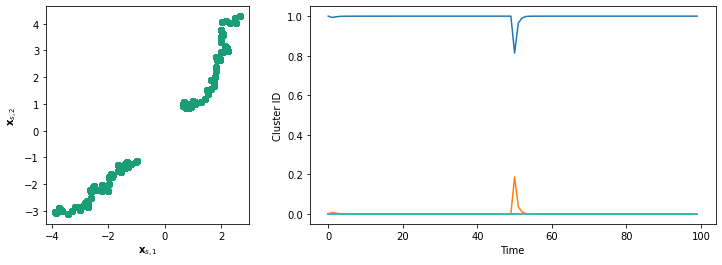

In [23]:
results = sem_run(x_train, sem_kwargs2)
plot_segmentation(results.post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:11<00:00,  8.67it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


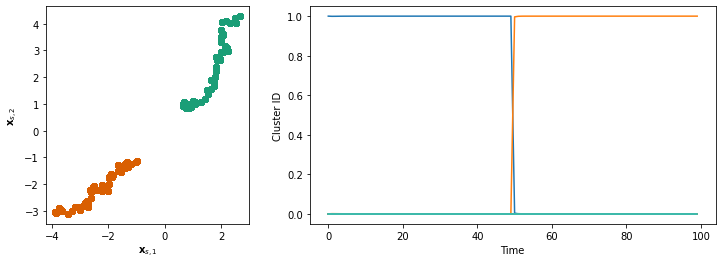

In [24]:
results = sem_run(x_train, sem_kwargs3)
plot_segmentation(results.post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


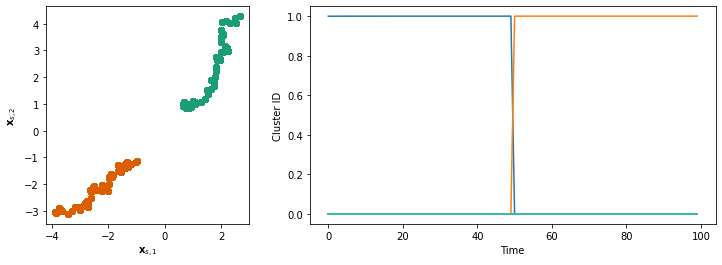

In [25]:
results = sem_run(x_train, sem_kwargs4)
plot_segmentation(results.post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:11<00:00,  8.74it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


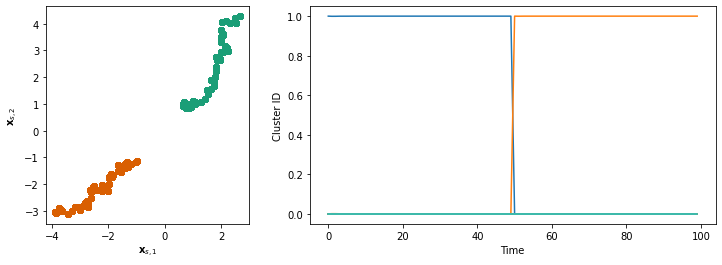

In [26]:
results = sem_run(x_train, sem_kwargs5)
plot_segmentation(results.post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:13<00:00,  7.63it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


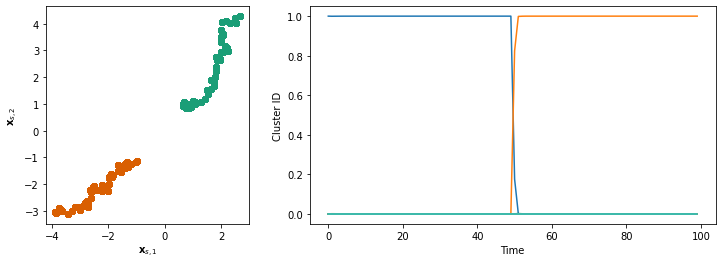

In [27]:
results = sem_run(x_train, sem_kwargs6)
plot_segmentation(results.post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


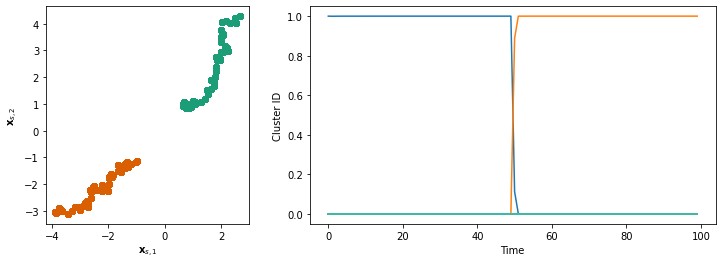

In [28]:
results = sem_run(x_train, sem_kwargs7)
plot_segmentation(results.post, y)

# Two alternating events with different levels of noise (10x)

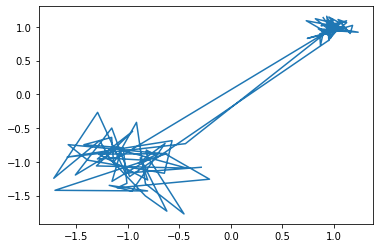

In [29]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.array([beta, beta * 10.])
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(int(N/4)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(int(N/4), int(N/2)):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
    for n in range(int(N/2), int(N/4*3)):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * stds[0])
    for n in range(int(N/4*3), N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * stds[1])
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int),
                    np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


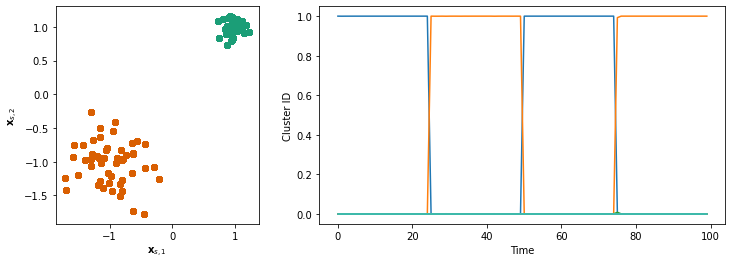

In [30]:
results = sem_run(x_train, sem_kwargs2)
plot_segmentation(results.post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


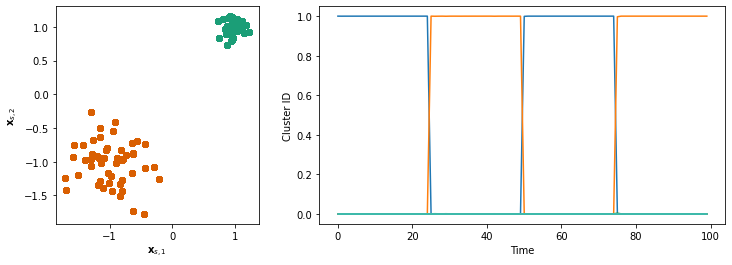

In [31]:
results = sem_run(x_train, sem_kwargs3)
plot_segmentation(results.post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


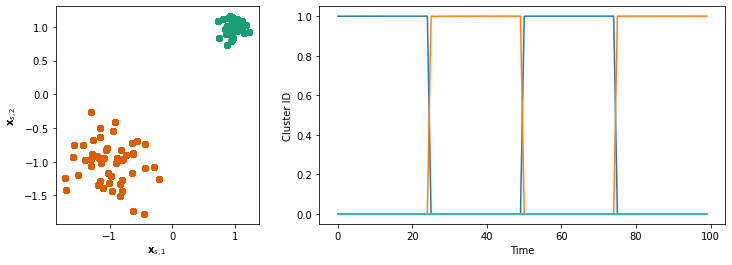

In [32]:
results = sem_run(x_train, sem_kwargs4)
plot_segmentation(results.post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:11<00:00,  8.76it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


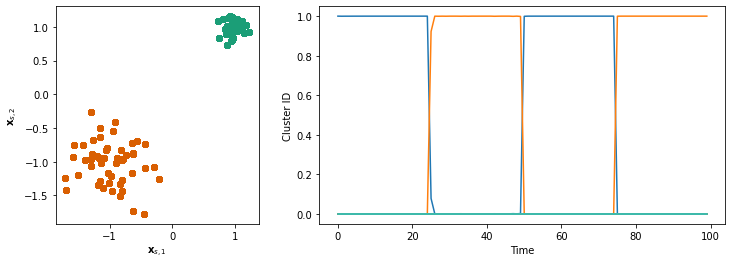

In [33]:
results = sem_run(x_train, sem_kwargs5)
plot_segmentation(results.post, y)

### GRU Events

Run SEM: 100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


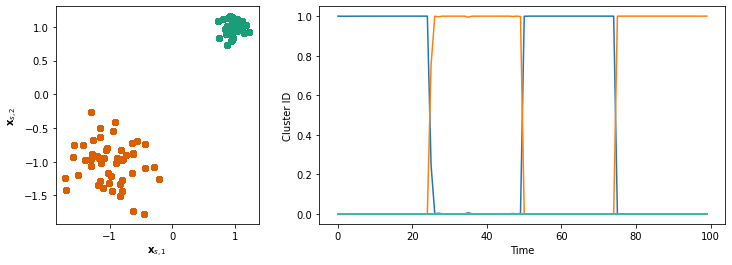

In [34]:
results = sem_run(x_train, sem_kwargs6)
plot_segmentation(results.post, y)

### LSTM Events

Run SEM: 100%|██████████| 100/100 [00:22<00:00,  4.53it/s]


Adjusted Rand Score: 0.9599960816486464

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


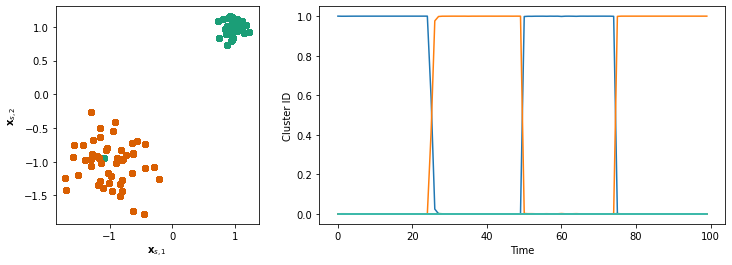

In [35]:
results = sem_run(x_train, sem_kwargs7)
plot_segmentation(results.post, y)

# 4 events where the events correspond to movement in vector space


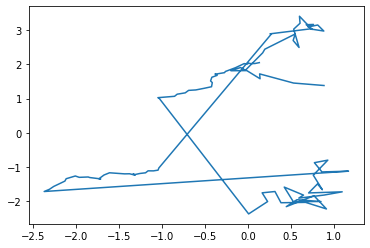

In [36]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigmas = [np.eye(2) * beta* 5.,
            np.eye(2) * beta / 5.,
            np.eye(2) * beta * 5.,
            np.eye(2) * beta / 5.]
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigmas[0])
    for n in range(1, int(N/4)):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[0])
        
    x[int(N/4), :] = np.random.multivariate_normal(bs[1], Sigmas[1])
    for n in range(int(N/4+1), int(N/2)):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[1])
            
    x[int(N/2), :] = np.random.multivariate_normal(bs[2], Sigmas[2])
    for n in range(int(N/2+1), int(N/4*3)):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[2])
        
    x[int(N/4*3), :] = np.random.multivariate_normal(bs[3], Sigmas[3])
    for n in range(int(N/4*3+1), N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigmas[3])      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear Events

Run SEM: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Adjusted Rand Score: 0.5881774920336341

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0]


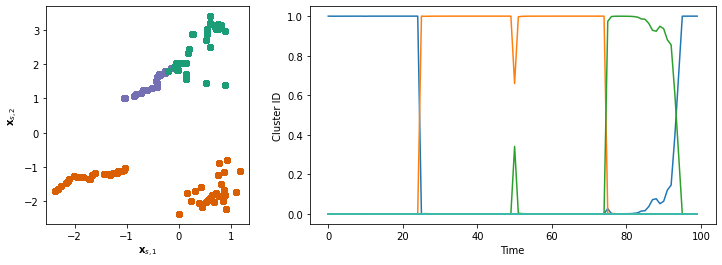

In [37]:
results = sem_run(x_train, sem_kwargs2)
plot_segmentation(results.post, y)

### Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


Adjusted Rand Score: 0.5689296480278521

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0]


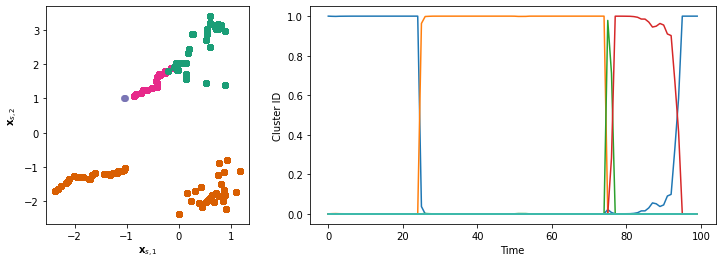

In [38]:
results = sem_run(x_train, sem_kwargs3)
plot_segmentation(results.post, y)

### Recurrent Linear Events

Run SEM: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Adjusted Rand Score: 0.32653061224489793

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


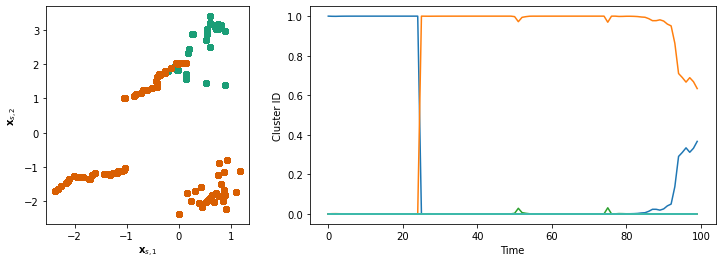

In [39]:
results = sem_run(x_train, sem_kwargs4)
plot_segmentation(results.post, y)

### Recurrent Non-linear Events

Run SEM: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


Adjusted Rand Score: 0.6754189708303432

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


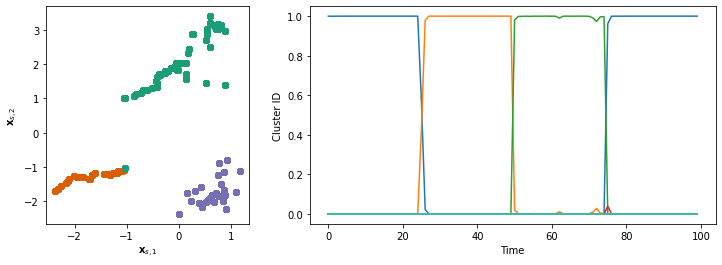

In [40]:
results = sem_run(x_train, sem_kwargs5)
plot_segmentation(results.post, y)

### GRU Events

In [ ]:
results = sem_run(x_train, sem_kwargs6)
plot_segmentation(results.post, y)

Run SEM:  50%|█████     | 50/100 [00:13<00:09,  5.51it/s]

### LSTM Events

In [ ]:
results = sem_run(x_train, sem_kwargs7)
plot_segmentation(results.post, y)